In [1]:
import xarray as xr
import numpy as np
import xcdat as xc
import xskillscore as xscore
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import seaborn as sns
# Set the default color cycle
import pandas as pd
import matplotlib as mpl

from scipy.stats import linregress
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, Sequence, cast

In [2]:
def create_scatter(x6, y6, x5: list = [], y5: list = [], vline=0, xlabel: str = "", ylabel: str = "", left_title: str = "", right_title: str ="") -> None:
    # Set the default color cycle
    colors = ['black','maroon','#7570b3']
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

    fontsize=14

    CMIP6_label = "CMIP6"
    
    if len(x5) != 0: 
        slope, intercept, r, p, _ = linregress(x5,y5)
        r, p = np.around(r, 3), np.around(p, 3)
        CMIP5_label = f"r={r}"
        plt.scatter(x5, y5, s=100, alpha=.5, edgecolor="black", color=colors[1], label=CMIP5_label)
        # plt.scatter(np.mean(x5), np.mean(y5), edgecolor="black", s=200, zorder=100, color=colors[1], marker="x")
        plt.plot(np.array(sorted(x6)), np.array(sorted(x6))*slope+intercept, color=colors[1], alpha=.5)

        slope, intercept, r, p, _ = linregress(x6,y6)
        r, p = np.around(r, 3), np.around(p, 3)
        plt.plot(np.array(sorted(x6)), np.array(sorted(x6))*slope+intercept, color=colors[0], alpha=.5)
        CMIP6_label = f"r={r}"
    
    plt.scatter(x6, y6, s=100, alpha=.5, edgecolor="black", color=colors[0], label=CMIP6_label)
    # plt.scatter(np.mean(x6), np.mean(y6), s=200, zorder=100, edgecolor="black", color=colors[0], marker="x")

    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.grid()
    if len(vline) != 0:
        plt.vlines(vline, ymin=-1.0, ymax=2.5, color="navy")

    x = np.concatenate((x6, x5))
    y = np.concatenate((y6, y5))
    # Sort the lists together based on list1
    x, y  = zip(*sorted(zip(x, y)))
    slope, intercept, r, p, _ = linregress(x,y)
    r, p = np.around(r, 3), np.around(p, 3)
    plt.plot(np.array(sorted(x)), np.array(sorted(x))*slope+intercept, color="black")
    plt.legend(loc="upper left", fontsize=fontsize)
    
    # plt.title(left_title, loc="left", fontweight="bold")
    plt.title(f"{right_title} r={r}", loc="left", fontweight="bold", fontsize=fontsize)
    
    fig = plt.gcf()
    fig.set_size_inches(6, 6)

    # Define border size - important for emphasizing relationships
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    borderx, bordery = .25*abs(np.max(x)), .25*abs(np.max(y))
    plt.xlim(xmin-borderx, xmax+borderx)
    plt.ylim(ymin-bordery, ymax+bordery)
    
    # Vertical Lines for Ensemble Means
    plt.vlines(np.mean(x5), ymin=ymin-bordery, ymax=ymax+bordery, color=colors[1], linestyle="--", label='_nolegend_', alpha=.5, zorder=0) 
    plt.vlines(np.mean(x6), ymin=ymin-bordery, ymax=ymax+bordery, color=colors[0], linestyle="--", label='_nolegend_', alpha=.5, zorder=0) 


def create_scatter_hists(x6, y6, x5: list = [], y5: list = [], vline=0, xlabel: str = "", ylabel: str = "", left_title: str = "", right_title: str ="") -> None: 
    colors = ['black','maroon','#7570b3']
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

    # Create Pandas DataFrame from lists
    x = np.concatenate((x6, x5))
    y = np.concatenate((y6, y5))
    cmip6 = pd.DataFrame([x6, y6], index=["X", "Y"])
    cmip5 = pd.DataFrame([x5, y5], index=["X", "Y"])
    labels6 = pd.DataFrame([["CMIP6" for i in range(len(x6))]], index=["Ensemble"])
    labels5 = pd.DataFrame([["CMIP5" for i in range(len(x5))]], index=["Ensemble"])
    fbs = cmip6.T.append(cmip5.T, ignore_index=True)
    ens = labels6.T.append(labels5.T, ignore_index=True)
    df = pd.concat([fbs, ens], axis=1)

    # Create JointGrid object using Seaborn containing histogram and scatterplot
    g = sns.JointGrid(data=df, x="X", y="Y", hue="Ensemble")
    g.plot_marginals(sns.kdeplot, fill=True, alpha=.5, legend=False)
    g.plot_joint(sns.scatterplot, s=100, alpha=.5, edgecolor="black", legend=False)

    
    # Define border size - important for emphasizing relationships
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    borderx, bordery = .25*abs(np.max(x)), .25*abs(np.max(y))

    g.ax_joint.vlines(vline, ymin=ymin-bordery, ymax=ymax+bordery, color="navy", linestyle="--", label='_nolegend_', alpha=.75) # COBE

    # Vertical Lines for Ensemble Means
    g.ax_joint.vlines(np.mean(x5), ymin=ymin-bordery, ymax=ymax+bordery, color=colors[1], linestyle="--", label='_nolegend_', alpha=.75, zorder=0) # COBE
    g.ax_joint.vlines(np.mean(x6), ymin=ymin-bordery, ymax=ymax+bordery, color=colors[0], linestyle="--", label='_nolegend_', alpha=.75, zorder=0) # COBE
    
    # Add Letter title
    fig = plt.gcf()
    plt.text(0.05, .9, left_title, fontsize = 16, transform=fig.transFigure, fontweight="bold", zorder=.1)
    # Plot Regression Line for Combined Ensemble
    x, y  = zip(*sorted(zip(x, y)))
    slope, intercept, r, p, _ = linregress(x,y)
    r, p = np.around(r, 3), np.around(p, 3)
    g.ax_joint.plot(np.array(x), np.array(x)*slope+intercept, color="black", linestyle="--", label='_nolegend_')
    g.ax_joint.grid()
    plt.text(.15, .75, f'r={r}', fontsize = 12, bbox = dict(edgecolor='white', facecolor = 'white', alpha = 0.5), transform=fig.transFigure, label='_nolegend_')

    # Add Regression Line for CMIP5 and CMIP6
    if len(x5) != 0: 
        slope, intercept, r5, p5, _ = linregress(x5,y5)
        r5, p5 = np.around(r5, 3), np.around(p5, 3)
        g.ax_joint.plot(np.array(x), np.array(x)*slope+intercept, color=colors[1], linestyle="solid")


        slope, intercept, r6, p6, _ = linregress(x6,y6)
        r6, p6 = np.around(r6, 3), np.around(p6, 3)
        g.ax_joint.plot(np.array(x), np.array(x)*slope+intercept, color=colors[0], linestyle="solid")

    # Clean up x and y limits and labels
    g.ax_joint.set_xlim(xmin-borderx, xmax+borderx)
    g.ax_joint.set_ylim(ymin-bordery, ymax+bordery)
    g.ax_joint.set_xlabel(xlabel)
    g.ax_joint.set_ylabel(ylabel)
    # plt.grid()
    plt.legend(labels=[f"CMIP5 r={r5}", f"CMIP6 r={r6}", "Obs"], bbox_to_anchor=(1,0), loc="lower right",  bbox_transform=fig.transFigure)

In [3]:
def get_shared_models(ds1: xr.Dataset, ds2: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
    shared_models = list(set(ds1.model.values).intersection(set(ds2.model.values)))
    return ds1.sel(model=shared_models), ds2.sel(model=shared_models)
    
swcf_cmip6, sst_ept_cmip6 = get_shared_models(xr.open_dataarray("data/piControl/swcf_east_sa_cmip6_v2.nc"), xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificTriangle_trend.nc"))
swcf_cmip5, sst_ept_cmip5 = get_shared_models(xr.open_dataarray("data/piControl/swcf_east_sa_cmip5_v2.nc"), xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacificTriangle_trend.nc"))

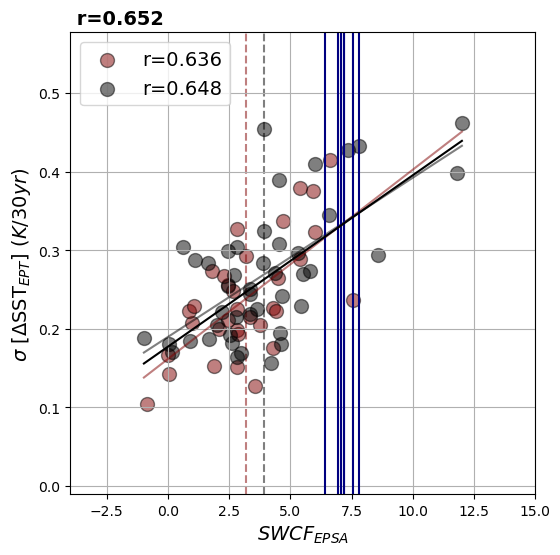

In [4]:
create_scatter(
    swcf_cmip6.values, 
    sst_ept_cmip6.std("time").values, 
    swcf_cmip5.values, 
    sst_ept_cmip5.std("time").values, 
    vline=[7.81434168, 7.17606042, 7.57042384, 6.95852917, 7.05380873, 6.41551741, 7.17404065], 
    left_title="A", 
    xlabel=r"$SWCF_{EPSA}$", 
    ylabel=r"$\sigma$ [$\Delta $SST$_{EPT}$] ($K/30yr$)"
)

In [5]:
import scipy.stats as stats
import random

mean = 0
# threshold = np.mean([-.228, -.22])  # Replace t with your desired threshold
threshold = np.mean([-0.30995762, -0.30437485, -0.24953692, -0.26466877, -0.30762401, -0.13590471, -0.24306433])
# obs_swcf = [9.033, 8.813, 9.20]
obs_swcf = [7.81434168, 7.17606042, 7.57042384, 6.95852917, 7.05380873, 6.41551741, 7.17404065] #[6.95681649, 6.74591779, 7.16189106, 6.3948513 , 6.54217176, 6.06338423, 6.7427297]
# obs_swcf = [10.5, 11.0]
sample_size = 40

swcf = xr.concat([swcf_cmip6, swcf_cmip5], dim="model")
sst_ept = xr.concat([sst_ept_cmip6, sst_ept_cmip5], dim="model")


# Bootstrap
niters = 2000
p_obs, p_model, p_diff = [], [], []
for iter in range(niters): 
    all_numbers = list(range(0, len(swcf.model.values)))
    # Shuffle the list to achieve randomness
    random.shuffle(all_numbers)
    # Select the first n elements from the shuffled list
    random_models = all_numbers[:sample_size]
    swcf_sub = swcf.isel(model=random_models)
    sst_ept_sub = sst_ept.isel(model=random_models)
    reg = linregress(swcf_sub.values, sst_ept_sub.std("time").values)
    # print(reg)
    # print(sst_ept_sub.var("time").values)
    # import pdb; pdb.set_trace() 
    estimated_obs_variance = reg.slope*np.mean(obs_swcf) + reg.intercept
    obs_normal_dist = stats.norm(loc=mean, scale=estimated_obs_variance)
    # print(obs_normal_dist.cdf(threshold))
    p_obs.append(obs_normal_dist.cdf(threshold))
    
    multimodel_mean_variance = sst_ept_sub.std("time").mean("model")
    # print(estimated_obs_variance, multimodel_mean_variance)
    # Create a normal distribution with the specified mean and variance
    model_normal_dist = stats.norm(loc=mean, scale=multimodel_mean_variance)
    # print(model_normal_dist.cdf(threshold))
    p_model.append(model_normal_dist.cdf(threshold))

    p_diff.append(obs_normal_dist.cdf(threshold) - model_normal_dist.cdf(threshold))

p_obs = np.array(p_obs)*100
p_model = np.array(p_model)*100
p_diff = np.array(p_diff)*100

In [6]:
x = np.linspace(-1., 1., 100)
reg = linregress(swcf.values, sst_ept.std("time").values)
estimated_obs_variance = reg.slope*np.mean(obs_swcf) + reg.intercept
obs_normal_dist = stats.norm(loc=mean, scale=estimated_obs_variance)

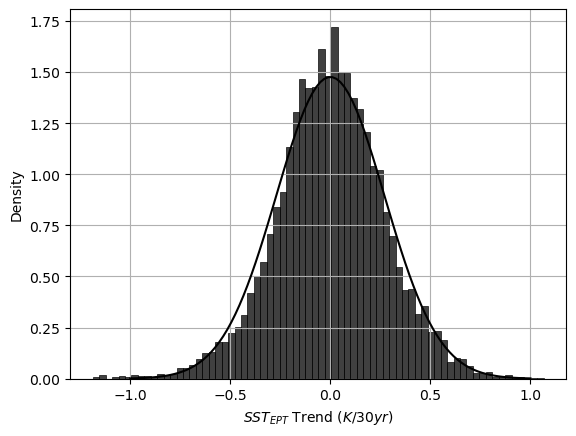

In [7]:
raw_normal_dist = stats.norm(loc=mean, scale=np.std(sst_ept.values.flatten()))
sns.histplot(sst_ept.values.flatten(), stat="density")
plt.plot(x, raw_normal_dist.pdf(x), label="obs")
plt.xlabel(r"$SST_{EPT}$ Trend ($K/30yr$)")
plt.grid()

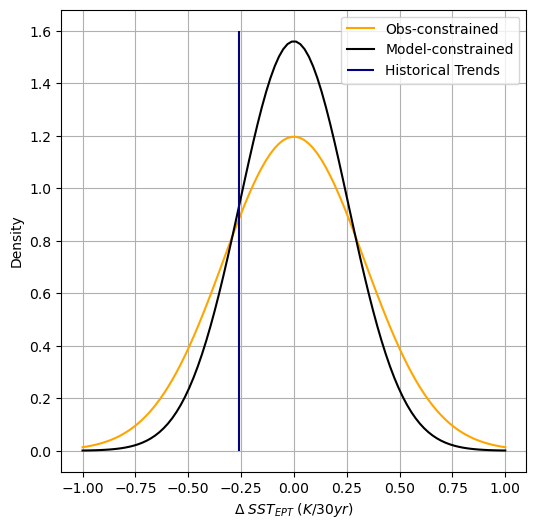

In [14]:
x = np.linspace(-1., 1., 100)
reg = linregress(swcf.values, sst_ept.std("time").values)
estimated_obs_variance = reg.slope*np.mean(obs_swcf) + reg.intercept
obs_normal_dist = stats.norm(loc=mean, scale=estimated_obs_variance)
model_normal_dist = stats.norm(loc=mean, scale=sst_ept.std("time").mean("model"))

plt.plot(x, obs_normal_dist.pdf(x), label="Obs-constrained", color="orange")
plt.plot(x, model_normal_dist.pdf(x), label="Model-constrained", color="black")
plt.vlines([threshold], ymin=0, ymax=1.6, color="navy", label="Historical Trends")  # Replace t with your desired threshold
plt.xlabel(r"$\Delta$ $SST_{EPT}$ ($K/30yr$)")
plt.ylabel("Density")
plt.legend()
plt.grid()
fig = plt.gcf()
fig.set_size_inches(6,6)
# sns.histplot()
# sns.histplot(p_model)

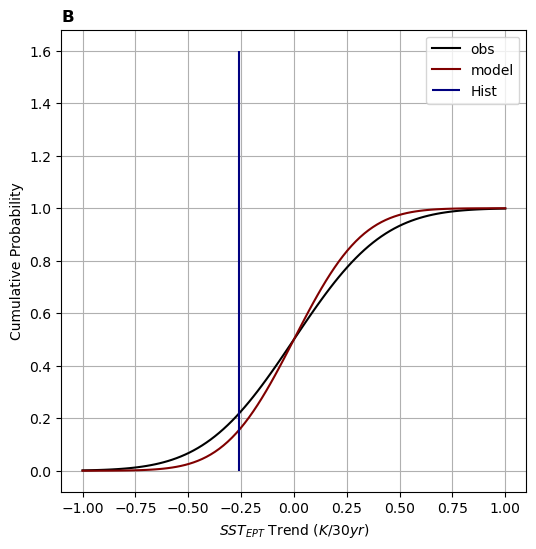

In [9]:
plt.plot(x, obs_normal_dist.cdf(x), label="obs")
plt.plot(x, model_normal_dist.cdf(x), label="model")
plt.vlines([threshold], ymin=0, ymax=1.6, color="navy", label="Hist")  # Replace t with your desired threshold
plt.legend()
plt.xlabel(r"$SST_{EPT}$ Trend ($K/30yr$)")
plt.ylabel(r"Cumulative Probability")
plt.title("B", fontweight="bold", loc="left")
fig = plt.gcf()
fig.set_size_inches(6, 6)

plt.grid()

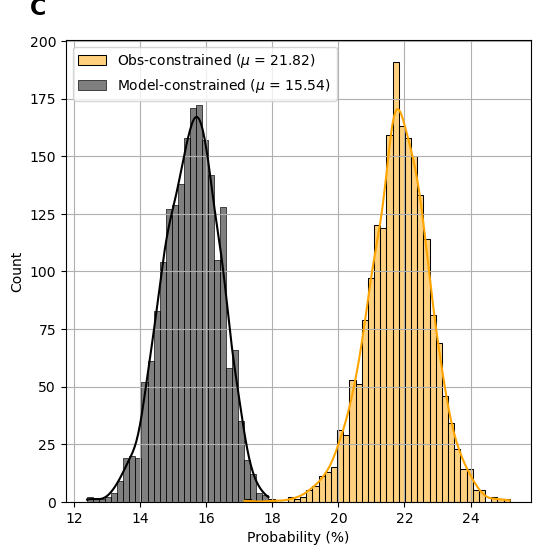

In [16]:

obs_mu = np.around(np.nanmean(p_obs), 2)
model_mu = np.around(np.nanmean(p_model), 2)
diff_mu = np.around(np.nanmean(p_diff), 2)
sns.histplot(p_obs, label=f"Obs-constrained ($\mu$ = {obs_mu})", kde=True, color="orange") #stat='density')
sns.histplot(p_model, label=f"Model-constrained ($\mu$ = {model_mu})", kde=True, color="black") #, stat='density')
plt.legend()
plt.grid()
plt.xlabel("Probability of Recent SST$_{EPT}$ Trend(%)")
# plt.title("C", fontweight="bold", loc="left")
plt.text(0.05, .9, "C", fontsize = 16, transform=fig.transFigure, fontweight="bold", zorder=.1)
fig = plt.gcf()
fig.set_size_inches(6, 6)

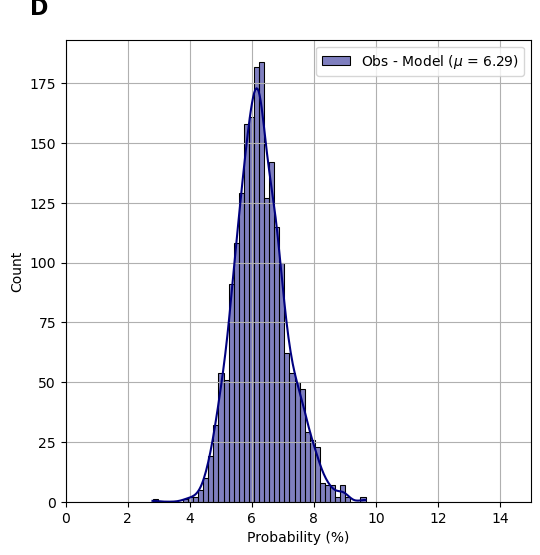

In [15]:
sns.histplot(p_diff, label=f"Obs - Model ($\mu$ = {diff_mu})", kde=True, color="navy") # color='#7570b3')
plt.xlim(0, 15)
plt.legend()
plt.grid()
plt.xlabel("Probability (%)")
# plt.title("D", fontweight="bold", loc="left", fontsize=16)
plt.text(0.05, .90, "D", fontsize = 16, transform=fig.transFigure, fontweight="bold", zorder=.1)
fig = plt.gcf()
fig.set_size_inches(6, 6)
